In [1]:
import numpy as np
import pandas as pd
import os

pd.options.display.max_colwidth = 1000

In [2]:
csv_save_dir = 'output_csvs_NEW_DATA'
if not os.path.exists(csv_save_dir):
    os.makedirs(csv_save_dir)

In [3]:
%%time

# Read information for the new records
records = pd.read_csv('new-citations-rerun.tsv', sep='\t', header=None)
records.columns = ['recID', 'oldRef', 'newRef', 'metaData']

print('Total Records: {}'.format(len(records)))

Total Records: 30230936
CPU times: user 2min 38s, sys: 8.99 s, total: 2min 47s
Wall time: 2min 48s


In [4]:
# Read the new citation counts
labs = pd.read_csv('new-citation-counts-rerun.tsv', sep='\t', header=None)
labs.columns = ['recID', 'Citation_Difference']
# Citation_Difference is actually citation count but is used here for ease later when subtracting

# Index by recIDs
labs_indexed = labs.set_index('recID')

In [5]:
# Read the legacy citation counts
legacy = pd.read_csv('old-citation-counts.tsv', sep='\t')
legacy.columns = ['recID', 'Citation_Difference']
# Citation_Difference is actually citation count but is used here for ease later when subtracting

# Index by recrod IDs
legacy_indexed = legacy.set_index('recID')

In [6]:
# Compute the difference in citation counts between Labs and Legacy
diff = labs_indexed - legacy_indexed

In [7]:
# Filter out the NaNs
is_nan = diff.Citation_Difference.isna()
NaN_entries = diff[is_nan]

print('{} articles are differently indexed between the legacy and labs records and have no correspondence'.format(len(NaN_entries)))

11434 articles are differently indexed between the legacy and labs records and have no correspondence


In [8]:
# Filter the valid entries
is_valid = ~diff.Citation_Difference.isna()
valid_diff = diff[is_valid]

In [9]:
# Get the articles which have lost citations
lost = valid_diff.Citation_Difference < 0
lost_citations = valid_diff[lost]

# Sort the list
lost_citations = lost_citations.sort_values('Citation_Difference')

In [10]:
# Get the articles which have gained citations
gained = valid_diff.Citation_Difference > 0
gained_citations = valid_diff[gained]

# Sort the list
gained_citations = gained_citations.sort_values('Citation_Difference', ascending=False)

In [124]:
# Get the counts for absolute differences in citation numbers
abs_diff = np.abs(valid_diff)
abs_diff = abs_diff.sort_values('Citation_Difference', ascending=False)

# Get just the zero difference entries
zero_diff = abs_diff.Citation_Difference == 0
zero_diff = abs_diff[zero_diff]

# Filter out the zero difference entries
non_zero_diff = abs_diff.Citation_Difference != 0
abs_diff = abs_diff[non_zero_diff]

In [12]:
# Initialize extended DataFrames for the differences
lost_citations_ext = lost_citations
gained_citations_ext = gained_citations
abs_diff_ext = abs_diff

# For lost citations
lost_citations_ext['Legacy_Count'] = legacy_indexed.loc[lost_citations.index]
lost_citations_ext['Labs_Count'] = labs_indexed.loc[lost_citations.index]

# For gained citations
gained_citations_ext['Legacy_Count'] = legacy_indexed.loc[gained_citations.index]
gained_citations_ext['Labs_Count'] = labs_indexed.loc[gained_citations.index]

# For absolute difference in citation counts
abs_diff_ext['Legacy_Count'] = legacy_indexed.loc[abs_diff.index]
abs_diff_ext['Labs_Count'] = labs_indexed.loc[abs_diff.index]

### Incorporate "invalid/NaN" entries

In [13]:
invalid_records = NaN_entries.index

In [14]:
legacy_NaNs = np.intersect1d(legacy_indexed.index, invalid_records)
legacy_only = legacy_indexed.loc[list(legacy_NaNs)]
len(legacy_only)

9097

In [15]:
labs_NaNs = np.intersect1d(labs_indexed.index, invalid_records)
labs_only = labs_indexed.loc[list(labs_NaNs)]
len(labs_only)

2337

In [16]:
# PLEASE RUN ONLY ONCE TO AVOID MULTIPLE APPENDS

# Initialize extended DataFrames for the "invalid" differences
legacy_only_ext = legacy_only
labs_only_ext = labs_only

# For legacy_only (Lost citations)
legacy_only_ext['Legacy_Count'] = legacy_only.Citation_Difference
legacy_only_ext['Labs_Count'] = 0


# For labs_only (Gained citations)
labs_only_ext['Legacy_Count'] = 0
labs_only_ext['Labs_Count'] = labs_only.Citation_Difference

# Append to the appropriate categories
abs_diff_ext = abs_diff_ext.append(legacy_only_ext)
abs_diff_ext = abs_diff_ext.append(labs_only_ext)
abs_diff_ext = abs_diff_ext.sort_values('Citation_Difference', ascending=False)

gained_citations_ext = gained_citations_ext.append(labs_only_ext)
gained_citations_ext = gained_citations_ext.sort_values('Citation_Difference', ascending=False)

legacy_only_ext.Citation_Difference = legacy_only_ext.Citation_Difference * -1
lost_citations_ext = lost_citations_ext.append(legacy_only_ext)
lost_citations_ext = lost_citations_ext.sort_values('Citation_Difference')

### Some useful statistics

In [17]:
# Indicate Number of articles with zero differences in citation counts
num_cited_legacy = len(legacy.index.unique())
num_cited_labs = len(labs.index.unique())
num_unique_articles = len(records.recID.unique())
total_unique_cited_articles = len(np.union1d(legacy_indexed.index, labs_indexed.index))
print('Total number of unique Cited articles as per legacy: {}'.format(num_cited_legacy))
print('Total number of unique Cited articles as per Labs: {}'.format(num_cited_labs))
print('Union of the above two - Total unique cited articles: {}'.format(total_unique_cited_articles))
print('\nTotal Number of Unique Articles which cite other papers: {}\n'.format(num_unique_articles))

num_zero_diff = valid_diff.Citation_Difference.value_counts()[0]
zero_diff = num_zero_diff / total_unique_cited_articles * 100
print('Number of Cited articles with zero difference: {}'.format(num_zero_diff))
print('Percentage of Cited articles with zero difference: {0:0.2f} %'.format(zero_diff))

Total number of unique Cited articles as per legacy: 760203
Total number of unique Cited articles as per Labs: 753443
Union of the above two - Total unique cited articles: 762540

Total Number of Unique Articles which cite other papers: 942172

Number of Cited articles with zero difference: 683539
Percentage of Cited articles with zero difference: 89.64 %


In [18]:
# Percentage Differences for absolute differences
abs_diff_counts = abs_diff_ext.Citation_Difference.value_counts()
print('Total Number of article with changes in citation counts in Labs: {}'.format(len(abs_diff_ext)))

print('\nNumber of articles with changes in Citation Counts in Labs')
print(abs_diff_counts[:5])

print('\nPercent (%) of Citation Counts Difference in Labs')
print(abs_diff_counts[:5] / total_unique_cited_articles * 100)

num_grt5 = sum(abs_diff_counts[6:])
percent_grt5 = num_grt5 / total_unique_cited_articles * 100
print('\nTotal {} records with difference greater than 5 - Percentage: {} %\n'.format(num_grt5, percent_grt5))

Total Number of article with changes in citation counts in Labs: 79001

Number of articles with changes in Citation Counts in Labs
1.0    61460
2.0     9039
3.0     2949
4.0     1410
5.0      835
Name: Citation_Difference, dtype: int64

Percent (%) of Citation Counts Difference in Labs
1.0    8.059905
2.0    1.185380
3.0    0.386734
4.0    0.184908
5.0    0.109502
Name: Citation_Difference, dtype: float64

Total 3308 records with difference greater than 5 - Percentage: 0.43381330815432634 %



In [19]:
# Percentage Differences for lost citations
lost_citations_count = lost_citations_ext.Citation_Difference.value_counts()
print('Total Number of article with loss in citation counts in Labs: {}'.format(len(lost_citations_ext)))

print('\nNumber of articles losing Citation Counts in Labs')
print(lost_citations_count[:-5])

lost_percent_diff = lost_citations_count/ total_unique_cited_articles * 100
print('\nPercent (%) of Citation Counts Lost in Labs')
print(lost_percent_diff[:-5])

lost_grt5 = sum(lost_citations_count[-6:])
lost_percent_grt5 = lost_grt5 / total_unique_cited_articles * 100
print('\nTotal {} records with lost citations greater than 5 - Percentage: {} %\n'.format(lost_grt5, lost_percent_grt5))

Total Number of article with loss in citation counts in Labs: 59523

Number of articles losing Citation Counts in Labs
-1.0    46100
-2.0     7016
-3.0     2175
-4.0     1013
-5.0      589
Name: Citation_Difference, dtype: int64

Percent (%) of Citation Counts Lost in Labs
-1.0    6.045584
-2.0    0.920083
-3.0    0.285231
-4.0    0.132845
-5.0    0.077242
Name: Citation_Difference, dtype: float64

Total 2630 records with lost citations greater than 5 - Percentage: 0.3448999396752957 %



In [20]:
# Percentage Differences for gained citations
gained_citations_count = gained_citations_ext.Citation_Difference.value_counts()
print('Total Number of article with gain in citation counts in Labs: {}'.format(len(gained_citations_ext)))

print('\nNumber of articles gaining Citation Counts in Labs')
print(gained_citations_count[:5])

gained_percent_diff = gained_citations_count/ total_unique_cited_articles * 100
print('\nPercent (%) of Citation Counts Gained in Labs')
print(gained_percent_diff[:5])


gained_grt5 = sum(gained_citations_count[6:])
gained_percent_grt5 = gained_grt5 / total_unique_cited_articles * 100
print('\nTotal {} records with gained citations greater than 5 - Percentage: {} %\n'.format(gained_grt5, gained_percent_grt5))

Total Number of article with gain in citation counts in Labs: 19478

Number of articles gaining Citation Counts in Labs
1.0    15360
2.0     2023
3.0      774
4.0      397
5.0      246
Name: Citation_Difference, dtype: int64

Percent (%) of Citation Counts Gained in Labs
1.0    2.014321
2.0    0.265298
3.0    0.101503
4.0    0.052063
5.0    0.032261
Name: Citation_Difference, dtype: float64

Total 678 records with gained citations greater than 5 - Percentage: 0.08891336847903061 %



### Analyze "Core-ness" of the records with citation differences

In [100]:
core_list = pd.read_csv('inspire_core.txt', sep='\n', header=None)

##### For Absolute differences

In [101]:
core_articles_with_diff = np.intersect1d(abs_diff_ext.index, core_list[0].unique())
non_core_articles_with_diff = np.setxor1d(core_articles_with_diff, abs_diff_ext.index)

print('Of {} records with citation differences, {} are CORE and {} are Non-Core'.format(len(abs_diff_ext), len(core_articles_with_diff), len(non_core_articles_with_diff)))

core_changed_citations = abs_diff_ext.loc[list(core_articles_with_diff)].Citation_Difference.sum()
non_core_changed_citations = abs_diff_ext.loc[list(non_core_articles_with_diff)].Citation_Difference.sum()

print('Of the above, CORE records have {} number of citations while Non-Core articles have {} different number of citations'.format(core_changed_citations, non_core_changed_citations))

core_articles_with_diff_ext = abs_diff_ext.loc[core_articles_with_diff].sort_values('Citation_Difference', ascending=False)
non_core_articles_with_diff_ext = abs_diff_ext.loc[non_core_articles_with_diff].sort_values('Citation_Difference', ascending=False)

Of 79001 records with citation differences, 53593 are CORE and 25408 are Non-Core
Of the above, CORE records have 133075.0 number of citations while Non-Core articles have 48645.0 different number of citations


In [103]:
# For Core
core_diff_counts = core_articles_with_diff_ext.Citation_Difference.value_counts()

print('\nNumber of CORE articles with changes in Citation Counts in Labs')
print(core_diff_counts[:5])

print('\nPercent (%) of CORE Citation Counts Difference in Labs')
print(core_diff_counts[:5] / total_unique_cited_articles * 100)

core_num_grt5 = sum(core_diff_counts[6:])
core_percent_grt5 = core_num_grt5 / total_unique_cited_articles * 100
print('\nTotal {} CORE records with difference greater than 5 - Percentage: {} %\n'.format(core_num_grt5, core_percent_grt5))


Number of CORE articles with changes in Citation Counts in Labs
1.0    41114
2.0     6184
3.0     2126
4.0     1003
5.0      606
Name: Citation_Difference, dtype: int64

Percent (%) of CORE Citation Counts Difference in Labs
1.0    5.391717
2.0    0.810974
3.0    0.278805
4.0    0.131534
5.0    0.079471
Name: Citation_Difference, dtype: float64

Total 2560 CORE records with difference greater than 5 - Percentage: 0.335720093372151 %



In [104]:
# For Non-Core
non_core_diff_counts = non_core_articles_with_diff_ext.Citation_Difference.value_counts()

print('\nNumber of non-CORE articles with changes in Citation Counts in Labs')
print(non_core_diff_counts[:5])

print('\nPercent (%) of non-CORE Citation Counts Difference in Labs')
print(non_core_diff_counts[:5] / total_unique_cited_articles * 100)

non_core_num_grt5 = sum(non_core_diff_counts[6:])
non_core_percent_grt5 = non_core_num_grt5 / total_unique_cited_articles * 100
print('\nTotal {} non-CORE records with difference greater than 5 - Percentage: {} %\n'.format(non_core_num_grt5, non_core_percent_grt5))


Number of non-CORE articles with changes in Citation Counts in Labs
1.0    20346
2.0     2855
3.0      823
4.0      407
5.0      229
Name: Citation_Difference, dtype: int64

Percent (%) of non-CORE Citation Counts Difference in Labs
1.0    2.668188
2.0    0.374407
3.0    0.107929
4.0    0.053374
5.0    0.030031
Name: Citation_Difference, dtype: float64

Total 748 non-CORE records with difference greater than 5 - Percentage: 0.09809321478217536 %



##### For Lost Citations

In [105]:
core_articles_with_loss = np.intersect1d(lost_citations_ext.index, core_list[0].unique())
non_core_articles_with_loss = np.setxor1d(core_articles_with_loss, lost_citations_ext.index)

print('Of {} records with citation losses, {} are CORE and {} are Non-Core'.format(len(lost_citations_ext), len(core_articles_with_loss), len(non_core_articles_with_loss)))

core_lost_citations = lost_citations_ext.loc[list(core_articles_with_loss)].Citation_Difference.sum()
non_core_lost_citations = lost_citations_ext.loc[list(non_core_articles_with_loss)].Citation_Difference.sum()

print('Of the above, CORE records have lost {} citations while Non-Core articles have lost {} citations'.format(abs(core_lost_citations), abs(non_core_lost_citations)))

core_articles_with_loss_ext = lost_citations_ext.loc[core_articles_with_loss].sort_values('Citation_Difference')
non_core_articles_with_loss_ext = lost_citations_ext.loc[non_core_articles_with_loss].sort_values('Citation_Difference')

Of 59523 records with citation losses, 39259 are CORE and 20264 are Non-Core
Of the above, CORE records have lost 104417.0 citations while Non-Core articles have lost 40217.0 citations


In [106]:
# For Core
core_lost_counts = core_articles_with_loss_ext.Citation_Difference.value_counts()

print('\nNumber of CORE articles with loss in Citation Counts in Labs')
print(core_lost_counts[:-5])

print('\nPercent (%) of CORE Citation Lost in Labs')
print(core_lost_counts[:-5] / total_unique_cited_articles * 100)

core_lost_grt5 = sum(core_lost_counts[-6:])
core_lost_percent_grt5 = core_lost_grt5 / total_unique_cited_articles * 100
print('\nTotal {} CORE records with loss greater than 5 - Percentage: {} %\n'.format(core_lost_grt5, core_lost_percent_grt5))


Number of CORE articles with loss in Citation Counts in Labs
-1.0    30021
-2.0     4626
-3.0     1495
-4.0      690
-5.0      412
Name: Citation_Difference, dtype: int64

Percent (%) of CORE Citation Lost in Labs
-1.0    3.936974
-2.0    0.606657
-3.0    0.196055
-4.0    0.090487
-5.0    0.054030
Name: Citation_Difference, dtype: float64

Total 2015 CORE records with loss greater than 5 - Percentage: 0.2642484328690954 %



In [107]:
# For Non-Core
non_core_lost_counts = non_core_articles_with_loss_ext.Citation_Difference.value_counts()

print('\nNumber of non-CORE articles with loss in Citation Counts in Labs')
print(non_core_lost_counts[:-5])

print('\nPercent (%) of non-CORE Citation Counts Lost in Labs')
print(non_core_lost_counts[:-5] / total_unique_cited_articles * 100)

non_core_lost_grt5 = sum(non_core_lost_counts[-6:])
non_core_lost_percent_grt5 = non_core_lost_grt5 / total_unique_cited_articles * 100
print('\nTotal {} Non-CORE records with loss greater than 5 - Percentage: {} %\n'.format(non_core_lost_grt5, non_core_lost_percent_grt5))


Number of non-CORE articles with loss in Citation Counts in Labs
-1.0    16079
-2.0     2390
-3.0      680
-4.0      323
-5.0      177
Name: Citation_Difference, dtype: int64

Percent (%) of non-CORE Citation Counts Lost in Labs
-1.0    2.108611
-2.0    0.313426
-3.0    0.089176
-4.0    0.042358
-5.0    0.023212
Name: Citation_Difference, dtype: float64

Total 615 Non-CORE records with loss greater than 5 - Percentage: 0.08065150680620034 %



##### For Gained Citations

In [108]:
core_articles_with_gain = np.intersect1d(gained_citations_ext.index, core_list[0].unique())
non_core_articles_with_gain = np.setxor1d(core_articles_with_gain, gained_citations_ext.index)

print('Of {} records with citation gains, {} are CORE and {} are Non-Core'.format(len(gained_citations_ext), len(core_articles_with_gain), len(non_core_articles_with_gain)))

core_gained_citations = gained_citations_ext.loc[list(core_articles_with_gain)].Citation_Difference.sum()
non_core_gained_citations = gained_citations_ext.loc[list(non_core_articles_with_gain)].Citation_Difference.sum()

print('Of the above, CORE records have gained {} citations while Non-Core articles have gained {} citations'.format(abs(core_gained_citations), abs(non_core_gained_citations)))

core_articles_with_gain_ext = gained_citations_ext.loc[core_articles_with_gain].sort_values('Citation_Difference', ascending=False)
non_core_articles_with_gain_ext = gained_citations_ext.loc[non_core_articles_with_gain].sort_values('Citation_Difference', ascending=False)

Of 19478 records with citation gains, 14334 are CORE and 5144 are Non-Core
Of the above, CORE records have gained 28658.0 citations while Non-Core articles have gained 8428.0 citations


In [109]:
# For Core
core_gained_counts = core_articles_with_gain_ext.Citation_Difference.value_counts()

print('\nNumber of CORE articles with gain in Citation Counts in Labs')
print(core_gained_counts[:5])

print('\nPercent (%) of CORE Citation Gained in Labs')
print(core_gained_counts[:5] / total_unique_cited_articles * 100)

core_gained_grt5 = sum(core_gained_counts[6:])
core_gained_percent_grt5 = core_gained_grt5 / total_unique_cited_articles * 100
print('\nTotal {} CORE records with gain greater than 5 - Percentage: {} %\n'.format(core_gained_grt5, core_gained_percent_grt5))


Number of CORE articles with gain in Citation Counts in Labs
1.0    11093
2.0     1558
3.0      631
4.0      313
5.0      194
Name: Citation_Difference, dtype: int64

Percent (%) of CORE Citation Gained in Labs
1.0    1.454743
2.0    0.204317
3.0    0.082750
4.0    0.041047
5.0    0.025441
Name: Citation_Difference, dtype: float64

Total 545 CORE records with gain greater than 5 - Percentage: 0.07147166050305559 %



In [110]:
# For Non-Core
non_core_gained_counts = non_core_articles_with_gain_ext.Citation_Difference.value_counts()

print('\nNumber of non-CORE articles with gain in Citation Counts in Labs')
print(non_core_gained_counts[:5])

print('\nPercent (%) of non-CORE Citation Counts Gained in Labs')
print(non_core_gained_counts[:5] / total_unique_cited_articles * 100)

non_core_gained_grt5 = sum(non_core_gained_counts[6:])
non_core_gained_percent_grt5 = non_core_gained_grt5 / total_unique_cited_articles * 100
print('\nTotal {} non-CORE records with gain greater than 5 - Percentage: {} %\n'.format(non_core_gained_grt5, non_core_gained_percent_grt5))


Number of non-CORE articles with gain in Citation Counts in Labs
1.0    4267
2.0     465
3.0     143
4.0      84
5.0      52
Name: Citation_Difference, dtype: int64

Percent (%) of non-CORE Citation Counts Gained in Labs
1.0    0.559577
2.0    0.060980
3.0    0.018753
4.0    0.011016
5.0    0.006819
Name: Citation_Difference, dtype: float64

Total 133 non-CORE records with gain greater than 5 - Percentage: 0.01744170797597503 %



##### For citations with zero difference

In [127]:
core_articles_with_zero_diff = np.intersect1d(zero_diff.index, core_list[0].unique())
non_core_articles_with_zero_diff = np.setxor1d(core_articles_with_zero_diff, zero_diff.index)

print('Of {} records with 0 citation differences, {} are CORE and {} are Non-Core'.format(len(zero_diff), len(core_articles_with_zero_diff), len(non_core_articles_with_zero_diff)))

Of 683539 records with 0 citation differences, 428428 are CORE and 255111 are Non-Core


### Analyze by "citeable"

In [111]:
citeable_list = pd.read_csv('inspire_citeable.txt', sep='\n', header=None)

##### For Absolute differences

In [112]:
citeable_articles_with_diff = np.intersect1d(abs_diff_ext.index, citeable_list[0].unique())
non_citeable_articles_with_diff = np.setxor1d(citeable_articles_with_diff, abs_diff_ext.index)

print('Of {} records with citation differences, {} are Citeable and {} are Non-Citeable'.format(len(abs_diff_ext), len(citeable_articles_with_diff), len(non_citeable_articles_with_diff)))

citeable_changed_citations = abs_diff_ext.loc[list(citeable_articles_with_diff)].Citation_Difference.sum()
non_citeable_changed_citations = abs_diff_ext.loc[list(non_citeable_articles_with_diff)].Citation_Difference.sum()

print('Of the above, Citeable records have {} number of citations while Non-Citeable articles have {} different number of citations'.format(citeable_changed_citations, non_citeable_changed_citations))

citeable_articles_with_diff_ext = abs_diff_ext.loc[citeable_articles_with_diff].sort_values('Citation_Difference', ascending=False)
non_citeable_articles_with_diff_ext = abs_diff_ext.loc[non_citeable_articles_with_diff].sort_values('Citation_Difference', ascending=False)

Of 79001 records with citation differences, 75620 are Citeable and 3381 are Non-Citeable
Of the above, Citeable records have 169691.0 number of citations while Non-Citeable articles have 12029.0 different number of citations


In [113]:
# For Citeable
citeable_diff_counts = citeable_articles_with_diff_ext.Citation_Difference.value_counts()

print('\nNumber of Citeable articles with changes in Citation Counts in Labs')
print(citeable_diff_counts[:5])

print('\nPercent (%) of Citeable Citation Counts Difference in Labs')
print(citeable_diff_counts[:5] / total_unique_cited_articles * 100)

citeable_num_grt5 = sum(citeable_diff_counts[6:])
citeable_percent_grt5 = citeable_num_grt5 / total_unique_cited_articles * 100
print('\nTotal {} Citeable records with difference greater than 5 - Percentage: {} %\n'.format(citeable_num_grt5, citeable_percent_grt5))


Number of Citeable articles with changes in Citation Counts in Labs
1.0    59116
2.0     8585
3.0     2783
4.0     1309
5.0      764
Name: Citation_Difference, dtype: int64

Percent (%) of Citeable Citation Counts Difference in Labs
1.0    7.752511
2.0    1.125843
3.0    0.364964
4.0    0.171663
5.0    0.100191
Name: Citation_Difference, dtype: float64

Total 3063 Citeable records with difference greater than 5 - Percentage: 0.4016838460933197 %



In [114]:
# For Non-Citeable
non_citeable_diff_counts = non_citeable_articles_with_diff_ext.Citation_Difference.value_counts()

print('\nNumber of non-Citeable articles with changes in Citation Counts in Labs')
print(non_citeable_diff_counts[:5])

print('\nPercent (%) of non-Citeable Citation Counts Difference in Labs')
print(non_citeable_diff_counts[:5] / total_unique_cited_articles * 100)

non_citeable_num_grt5 = sum(non_citeable_diff_counts[6:])
non_citeable_percent_grt5 = non_citeable_num_grt5 / total_unique_cited_articles * 100
print('\nTotal {} non-Citeable records with difference greater than 5 - Percentage: {} %\n'.format(non_citeable_num_grt5, non_citeable_percent_grt5))


Number of non-Citeable articles with changes in Citation Counts in Labs
1.0    2344
2.0     454
3.0     166
4.0     101
5.0      71
Name: Citation_Difference, dtype: int64

Percent (%) of non-Citeable Citation Counts Difference in Labs
1.0    0.307394
2.0    0.059538
3.0    0.021769
4.0    0.013245
5.0    0.009311
Name: Citation_Difference, dtype: float64

Total 208 non-Citeable records with difference greater than 5 - Percentage: 0.027277257586487268 %



##### For Lost Citations

In [115]:
citeable_articles_with_loss = np.intersect1d(lost_citations_ext.index, citeable_list[0].unique())
non_citeable_articles_with_loss = np.setxor1d(citeable_articles_with_loss, lost_citations_ext.index)

print('Of {} records with citation losses, {} are Citeable and {} are Non-Citeable'.format(len(lost_citations_ext), len(citeable_articles_with_loss), len(non_citeable_articles_with_loss)))

citeable_lost_citations = lost_citations_ext.loc[list(citeable_articles_with_loss)].Citation_Difference.sum()
non_citeable_lost_citations = lost_citations_ext.loc[list(non_citeable_articles_with_loss)].Citation_Difference.sum()

print('Of the above, Citeable records have lost {} citations while Non-Citeable articles have lost {} citations'.format(abs(citeable_lost_citations), abs(non_citeable_lost_citations)))

citeable_articles_with_loss_ext = lost_citations_ext.loc[citeable_articles_with_loss].sort_values('Citation_Difference')
non_citeable_articles_with_loss_ext = lost_citations_ext.loc[non_citeable_articles_with_loss].sort_values('Citation_Difference')

Of 59523 records with citation losses, 56947 are Citeable and 2576 are Non-Citeable
Of the above, Citeable records have lost 133837.0 citations while Non-Citeable articles have lost 10797.0 citations


In [116]:
# For Citeable
citeable_lost_counts = citeable_articles_with_loss_ext.Citation_Difference.value_counts()

print('\nNumber of Citeable articles with loss in Citation Counts in Labs')
print(citeable_lost_counts[:-5])

print('\nPercent (%) of Citeable Citation Lost in Labs')
print(citeable_lost_counts[:-5] / total_unique_cited_articles * 100)

citeable_lost_grt5 = sum(citeable_lost_counts[-6:])
citeable_lost_percent_grt5 = citeable_lost_grt5 / total_unique_cited_articles * 100
print('\nTotal {} Citeable records with loss greater than 5 - Percentage: {} %\n'.format(citeable_lost_grt5, citeable_lost_percent_grt5))


Number of Citeable articles with loss in Citation Counts in Labs
-1.0    44373
-2.0     6669
-3.0     2047
-4.0      932
-5.0      528
Name: Citation_Difference, dtype: int64

Percent (%) of Citeable Citation Lost in Labs
-1.0    5.819105
-2.0    0.874577
-3.0    0.268445
-4.0    0.122223
-5.0    0.069242
Name: Citation_Difference, dtype: float64

Total 2398 Citeable records with loss greater than 5 - Percentage: 0.31447530621344455 %



In [117]:
# For Non-Citeable
non_citeable_lost_counts = non_citeable_articles_with_loss_ext.Citation_Difference.value_counts()

print('\nNumber of non-Citeable articles with loss in Citation Counts in Labs')
print(non_citeable_lost_counts[:-5])

print('\nPercent (%) of non-Citeable Citation Counts Lost in Labs')
print(non_citeable_lost_counts[:-5] / total_unique_cited_articles * 100)

non_citeable_lost_grt5 = sum(non_citeable_lost_counts[-6:])
non_citeable_lost_percent_grt5 = non_citeable_lost_grt5 / total_unique_cited_articles * 100
print('\nTotal {} Non-Citeable records with loss greater than 5 - Percentage: {} %\n'.format(non_citeable_lost_grt5, non_citeable_lost_percent_grt5))


Number of non-Citeable articles with loss in Citation Counts in Labs
-1.0    1727
-2.0     347
-3.0     128
-4.0      81
-5.0      61
Name: Citation_Difference, dtype: int64

Percent (%) of non-Citeable Citation Counts Lost in Labs
-1.0    0.226480
-2.0    0.045506
-3.0    0.016786
-4.0    0.010622
-5.0    0.008000
Name: Citation_Difference, dtype: float64

Total 197 Non-Citeable records with loss greater than 5 - Percentage: 0.025834710310278806 %



##### For Gained Citations

In [118]:
citeable_articles_with_gain = np.intersect1d(gained_citations_ext.index, citeable_list[0].unique())
non_citeable_articles_with_gain = np.setxor1d(citeable_articles_with_gain, gained_citations_ext.index)

print('Of {} records with citation gains, {} are Citeable and {} are Non-Citeable'.format(len(gained_citations_ext), len(citeable_articles_with_gain), len(non_citeable_articles_with_gain)))

citeable_gained_citations = gained_citations_ext.loc[list(citeable_articles_with_gain)].Citation_Difference.sum()
non_citeable_gained_citations = gained_citations_ext.loc[list(non_citeable_articles_with_gain)].Citation_Difference.sum()

print('Of the above, Citeable records have gained {} citations while Non-Citeable articles have gained {} citations'.format(abs(citeable_gained_citations), abs(non_citeable_gained_citations)))

citeable_articles_with_gain_ext = gained_citations_ext.loc[citeable_articles_with_gain].sort_values('Citation_Difference', ascending=False)
non_citeable_articles_with_gain_ext = gained_citations_ext.loc[non_citeable_articles_with_gain].sort_values('Citation_Difference', ascending=False)

Of 19478 records with citation gains, 18673 are Citeable and 805 are Non-Citeable
Of the above, Citeable records have gained 35854.0 citations while Non-Citeable articles have gained 1232.0 citations


In [119]:
# For Citeable
citeable_gained_counts = citeable_articles_with_gain_ext.Citation_Difference.value_counts()

print('\nNumber of Citeable articles with gain in Citation Counts in Labs')
print(citeable_gained_counts[:5])

print('\nPercent (%) of Citeable Citation Gained in Labs')
print(citeable_gained_counts[:5] / total_unique_cited_articles * 100)

citeable_gained_grt5 = sum(citeable_gained_counts[6:])
citeable_gained_percent_grt5 = citeable_gained_grt5 / total_unique_cited_articles * 100
print('\nTotal {} Citeable records with gain greater than 5 - Percentage: {} %\n'.format(citeable_gained_grt5, citeable_gained_percent_grt5))


Number of Citeable articles with gain in Citation Counts in Labs
1.0    14743
2.0     1916
3.0      736
4.0      377
5.0      236
Name: Citation_Difference, dtype: int64

Percent (%) of Citeable Citation Gained in Labs
1.0    1.933407
2.0    0.251266
3.0    0.096520
4.0    0.049440
5.0    0.030949
Name: Citation_Difference, dtype: float64

Total 665 Citeable records with gain greater than 5 - Percentage: 0.08720853987987515 %



In [120]:
# For Non-Citeable
non_citeable_gained_counts = non_citeable_articles_with_gain_ext.Citation_Difference.value_counts()

print('\nNumber of non-Citeable articles with gain in Citation Counts in Labs')
print(non_citeable_gained_counts[:5])

print('\nPercent (%) of non-Citeable Citation Counts Gained in Labs')
print(non_citeable_gained_counts[:5] / total_unique_cited_articles * 100)

non_citeable_gained_grt5 = sum(non_citeable_gained_counts[6:])
non_citeable_gained_percent_grt5 = non_citeable_gained_grt5 / total_unique_cited_articles * 100
print('\nTotal {} non-Citeable records with gain greater than 5 - Percentage: {} %\n'.format(non_citeable_gained_grt5, non_citeable_gained_percent_grt5))


Number of non-Citeable articles with gain in Citation Counts in Labs
1.0    617
2.0    107
3.0     38
4.0     20
5.0     10
Name: Citation_Difference, dtype: int64

Percent (%) of non-Citeable Citation Counts Gained in Labs
1.0    0.080914
2.0    0.014032
3.0    0.004983
4.0    0.002623
5.0    0.001311
Name: Citation_Difference, dtype: float64

Total 9 non-Citeable records with gain greater than 5 - Percentage: 0.0011802659532614682 %



##### For citations with zero difference

In [128]:
citeable_articles_with_zero_diff = np.intersect1d(zero_diff.index, citeable_list[0].unique())
non_citeable_articles_with_zero_diff = np.setxor1d(citeable_articles_with_zero_diff, zero_diff.index)

print('Of {} records with 0 citation differences, {} are Citeable and {} are Non-Citeable'.format(len(zero_diff), len(citeable_articles_with_zero_diff), len(non_citeable_articles_with_zero_diff)))

Of 683539 records with 0 citation differences, 673398 are Citeable and 10141 are Non-Citeable


### Investigating the CORE most Lost citations

In [136]:
loss_greater_than_five = core_articles_with_loss_ext.Citation_Difference < -5
loss_greater_than_five = core_articles_with_loss_ext[loss_greater_than_five]

In [289]:
# Function to query the API for a record's metadata
import requests
def get_metadata(recid):
    url = 'http://localhost:5000/api/literature/'+str(recid)
    json_data = requests.get(url).json()
    try:
        if json_data['metadata']:
            return json_data['metadata']
    except:
        return None

In [ ]:
books_list = []
year_all_dict = {}
year_nobook_dict = {}
journal_list = []

for i, recid in enumerate(loss_greater_than_five.index):
    
    metadata = get_metadata(recid)
    if metadata:
        try:
            if 'book' in metadata['document_type'][0]:
                books_list.append(recid)
        except:
            pass
        try:
            if metadata['publication_info'][0]['year']:
                year_all_dict[recid] = int(metadata['publication_info'][0]['year'])
                if not 'book' in metadata['document_type'][0]:
                    year_nobook_dict[recid] = int(metadata['publication_info'][0]['year'])
        except:
            pass
        try:
            if metadata['publication_info'][0]['journal_title']:
                journal_list.append(metadata['publication_info'][0]['journal_title'])
        except:
            pass
    
    if i % 10 == 0:
        print('{}/{} Completed'.format(i, len(loss_greater_than_five)))

In [371]:
print('Of the {} records, {} are books'.format(len(loss_greater_than_five), len(books_list)))

Of the 2015 records, 752 are books


997 records have an associated year in the publication info (Plotted below)


(array([ 1.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,
         0.,  0.,  0.,  3.,  1.,  0.,  0.,  1.,  4.,  2.,  7.,  3.,  6.,
        15., 16., 17., 11., 32., 46., 56., 64., 27., 24., 44., 44., 29.,
        30., 32., 76., 53., 62., 63., 59., 68., 39., 25., 33.]),
 array([1912.  , 1914.12, 1916.24, 1918.36, 1920.48, 1922.6 , 1924.72,
        1926.84, 1928.96, 1931.08, 1933.2 , 1935.32, 1937.44, 1939.56,
        1941.68, 1943.8 , 1945.92, 1948.04, 1950.16, 1952.28, 1954.4 ,
        1956.52, 1958.64, 1960.76, 1962.88, 1965.  , 1967.12, 1969.24,
        1971.36, 1973.48, 1975.6 , 1977.72, 1979.84, 1981.96, 1984.08,
        1986.2 , 1988.32, 1990.44, 1992.56, 1994.68, 1996.8 , 1998.92,
        2001.04, 2003.16, 2005.28, 2007.4 , 2009.52, 2011.64, 2013.76,
        2015.88, 2018.  ]),
 <a list of 50 Patch objects>)

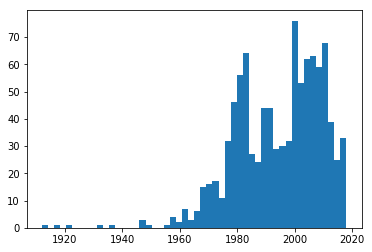

In [380]:
# Year information (All)
print('{} records have an associated year in the publication info (Plotted below)'.format(len(year_all_dict)))
plt.hist(year_all_dict.values(), bins=50)

810 records (excluding books) have an associated year in the publication info (Plotted below)


(array([ 1.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,
         0.,  0.,  0.,  3.,  1.,  0.,  0.,  1.,  4.,  1.,  7.,  3.,  6.,
        15., 16., 17., 11., 31., 41., 53., 56., 24., 18., 29., 32., 23.,
        25., 25., 62., 45., 42., 46., 49., 45., 25., 21., 28.]),
 array([1912.  , 1914.12, 1916.24, 1918.36, 1920.48, 1922.6 , 1924.72,
        1926.84, 1928.96, 1931.08, 1933.2 , 1935.32, 1937.44, 1939.56,
        1941.68, 1943.8 , 1945.92, 1948.04, 1950.16, 1952.28, 1954.4 ,
        1956.52, 1958.64, 1960.76, 1962.88, 1965.  , 1967.12, 1969.24,
        1971.36, 1973.48, 1975.6 , 1977.72, 1979.84, 1981.96, 1984.08,
        1986.2 , 1988.32, 1990.44, 1992.56, 1994.68, 1996.8 , 1998.92,
        2001.04, 2003.16, 2005.28, 2007.4 , 2009.52, 2011.64, 2013.76,
        2015.88, 2018.  ]),
 <a list of 50 Patch objects>)

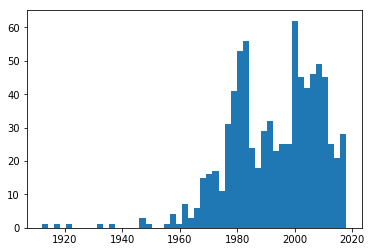

In [381]:
# Year information (No books)
print('{} records (excluding books) have an associated year in the publication info (Plotted below)'.format(len(year_nobook_dict)))
plt.hist(year_nobook_dict.values(), bins=50)

In [376]:
journal_df = pd.DataFrame(journal_list)
unique_journals = journal_df[0].value_counts()
print('{} records have a journal title, of which there are {} unique journals. Of which journals which appear the most are:'.format(len(journal_list), len(unique_journals)))
unique_journals[:20]

917 records have a journal title, of which there are 154 unique journals. Of which journals which appear the most are:


Phys.Lett.B                                117
Nucl.Instrum.Meth.A                         60
Phys.Rev.D                                  55
Phys.Rev.Lett.                              41
Nucl.Phys.B                                 38
Lect.Notes Phys.                            34
Nuovo Cim.A                                 29
Eur.Phys.J.C                                25
Nucl.Phys.B Proc.Suppl.                     23
Int.J.Mod.Phys.A                            22
Phys.Rept.                                  20
Camb.Monogr.Part.Phys.Nucl.Phys.Cosmol.     15
AIP Conf.Proc.                              15
PoS                                         14
Eur.Phys.J.A                                13
Acta Phys.Polon.B                           13
JHEP                                        12
Nucl.Phys.A                                 12
Front.Phys.                                 11
Conf.Proc.C                                 10
Name: 0, dtype: int64

# Please ignore after this
### Investiagte non-existent "cited" articles

In [26]:
non_overlapping = np.setdiff1d(np.union1d(records.oldRef.unique(), legacy.recID.unique()), np.intersect1d(records.oldRef.unique(), legacy.recID.unique()))
non_overlapping = non_overlapping[1:] # Remove entry for Zero

In [27]:
print('List from Legacy machine and from ES queries has {} non-overlapping records'.format(len(non_overlapping)))

List from Legacy machine and from ES queries has 5289 non-overlapping records


In [50]:
cited_in_dump_but_not_bibrank = []
cited_in_bibrank_but_not_dump = []
for article in non_overlapping:
    if len(records[records.oldRef == article]) != 0:
        cited_in_dump_but_not_bibrank.append(article)
    if len(legacy[legacy.recID == article]) != 0:
        cited_in_bibrank_but_not_dump.append(article)

In [100]:
cited_in_bibrank = legacy_indexed.loc[cited_in_bibrank_but_not_dump]

In [101]:
cited_in_dump = pd.DataFrame(records.oldRef.value_counts()[cited_in_dump_but_not_bibrank])
cited_in_dump.columns = ['Citation_Difference']